In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load data

In [124]:
df = pd.read_excel(".\\Data\\WA_Fn-UseC_-HR-Employee-Attrition.xlsx")

In [125]:
df.shape

(1470, 35)

In [126]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


# Step 2: Clean data

In [127]:
print("--- Check for missing values ---")
print(df.isnull().sum())

print("--- Check for NaN values ---")
print(df.isna().sum())

print("--- Check for data types ---")
print(df.info())

--- Check for missing values ---
Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsIn

In [128]:
print(df["Attrition"].unique())
print(df["BusinessTravel"].unique())
print(df["Department"].unique())
print(df["EducationField"].unique())
print(df["Gender"].unique())
print(df["JobRole"].unique())
print(df["MaritalStatus"].unique())
print(df["Over18"].unique())
print(df["OverTime"].unique())

['Yes' 'No']
['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']
['Sales' 'Research & Development' 'Human Resources']
['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']
['Female' 'Male']
['Sales Executive' 'Research Scientist' 'Laboratory Technician'
 'Manufacturing Director' 'Healthcare Representative' 'Manager'
 'Sales Representative' 'Research Director' 'Human Resources']
['Single' 'Married' 'Divorced']
['Y']
['Yes' 'No']


In [129]:
cleaned_df = df.drop(["Over18"], axis=1) # All values are "Y"
cleaned_df = cleaned_df.drop(["EmployeeNumber"], axis=1) # All values are unique
cleaned_df = cleaned_df.drop(["EmployeeCount"], axis=1) # All values are 1
cleaned_df = cleaned_df.drop(["StandardHours"], axis=1) # All values are 80

In [130]:
cleaned_df = pd.get_dummies(cleaned_df, columns=['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime'], dtype=pd.Int64Dtype())
cleaned_df = cleaned_df.drop(["Attrition_No"], axis=1) # Redundant
cleaned_df.head()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,41,1102,1,2,2,94,3,2,4,5993,...,0,0,0,1,0,0,0,1,0,1
1,49,279,8,1,3,61,2,2,2,5130,...,0,0,1,0,0,0,1,0,1,0
2,37,1373,2,2,4,92,2,1,3,2090,...,0,0,0,0,0,0,0,1,0,1
3,33,1392,3,4,4,56,3,1,3,2909,...,0,0,1,0,0,0,1,0,0,1
4,27,591,2,1,1,40,3,1,2,3468,...,0,0,0,0,0,0,1,0,1,0


# Step 3: Explore data

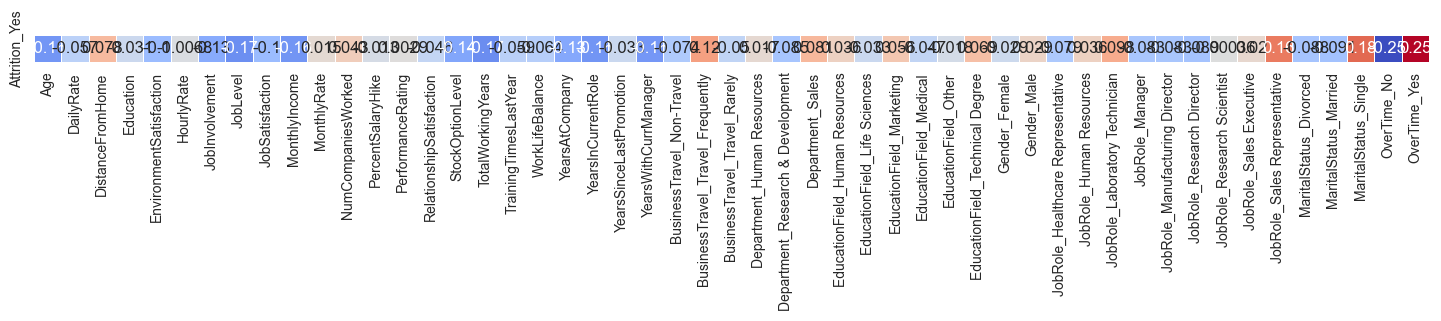

Attrition_Yes                        1.000000
OverTime_Yes                         0.246118
MaritalStatus_Single                 0.175419
JobRole_Sales Representative         0.157234
BusinessTravel_Travel_Frequently     0.115143
JobRole_Laboratory Technician        0.098290
Department_Sales                     0.080855
DistanceFromHome                     0.077924
EducationField_Technical Degree      0.069355
EducationField_Marketing             0.055781
NumCompaniesWorked                   0.043494
EducationField_Human Resources       0.036466
JobRole_Human Resources              0.036215
Gender_Male                          0.029453
JobRole_Sales Executive              0.019774
Department_Human Resources           0.016832
MonthlyRate                          0.015170
PerformanceRating                    0.002889
JobRole_Research Scientist          -0.000360
HourlyRate                          -0.006846
PercentSalaryHike                   -0.013478
EducationField_Other              

In [131]:
df_corr = cleaned_df.corr()

plt.figure(figsize=(18, 16))
sns.heatmap(df_corr['Attrition_Yes'].drop('Attrition_Yes').to_frame().T, annot=True, cmap='coolwarm', linewidths=0.5, cbar=False, square=True)
plt.show()

# Using the absolute value of the correlation, we can find the attribute that is closest to zero
df_attrition_yes_corr = df_corr['Attrition_Yes'].sort_values(ascending=False)
print(df_attrition_yes_corr)

closest_to_zero = df_attrition_yes_corr.abs().idxmin()
print(f"\nClosest to zero: {closest_to_zero}")

(1470, 52)
(1470, 33)


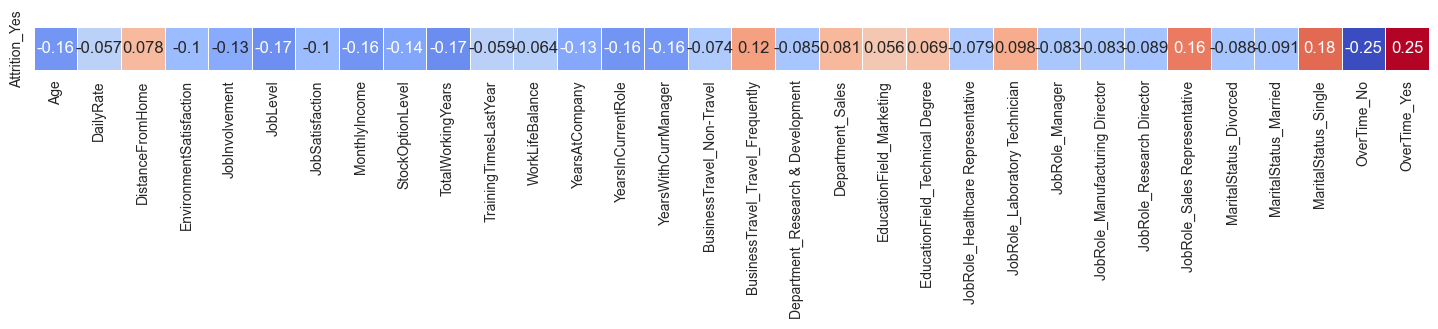

In [132]:
# Drop all columns that have a correlation of less than 5%
print(cleaned_df.shape)
cleaned_df = cleaned_df.drop(df_attrition_yes_corr[(df_attrition_yes_corr < 0.05) & (df_attrition_yes_corr > -0.05)].index, axis=1)
print(cleaned_df.shape)

df_corr = cleaned_df.corr()

plt.figure(figsize=(18, 16))
sns.heatmap(df_corr['Attrition_Yes'].drop('Attrition_Yes').to_frame().T, annot=True, cmap='coolwarm', linewidths=0.5, cbar=False, square=True)
plt.show()

# Step 4: Supervised machine learning

In [133]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error

import gc

set_prop = 0.2
seed = 42

In [134]:
# Random forest with transformed data

df = cleaned_df.dropna()

# Split the data into features and target
X = df.drop('Attrition_Yes', axis=1)
y = df['Attrition_Yes']

# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=set_prop, random_state=seed)

# Create and train the model
RFCmodel = RandomForestClassifier(n_estimators=100)
RFCmodel.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = RFCmodel.predict(X_test)

score = RFCmodel.score(X_test, y_test)
print(f"R2 accuracy score: {score}")

mse = mean_squared_error(y_test, y_pred)
print(f"Mean squared error: {mse}")

rmse = root_mean_squared_error(y_test, y_pred)
print(f"Root mean squared error: {rmse}")

R2 accuracy score: 0.8605442176870748
Mean squared error: 0.13945578231292516
Root mean squared error: 0.3734377890799553


In [135]:
# Bernoulli Naive Bayes with transformed data

# Create and train the model
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = BNBmodel.predict(X_test)

score = BNBmodel.score(X_test, y_test)
print(f"Accuracy score: {score}")

mse = mean_squared_error(y_test, y_pred)
print(f"Mean squared error: {mse}")

rmse = root_mean_squared_error(y_test, y_pred)
print(f"Root mean squared error: {rmse}")

Accuracy score: 0.8095238095238095
Mean squared error: 0.19047619047619047
Root mean squared error: 0.4364357804719847


In [136]:
# Voting classifier with transformed data and Random Forest and Bernoulli Naive Bayes

# Create and train the model
VCmodel = VotingClassifier(estimators=[('rf', RFCmodel), ('nb', BNBmodel)], voting='soft')
VCmodel.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = VCmodel.predict(X_test)

score = VCmodel.score(X_test, y_test)
print(f"Accuracy score: {score}")

mse = mean_squared_error(y_test, y_pred)
print(f"Mean squared error: {mse}")

rmse = root_mean_squared_error(y_test, y_pred)
print(f"Root mean squared error: {rmse}")

Accuracy score: 0.8401360544217688
Mean squared error: 0.1598639455782313
Root mean squared error: 0.39982989580349204


In [137]:
# Pickle the model
import pickle

filename = "bestfit_model.save"
pickle.dump(RFCmodel, open(filename, 'wb'))

# Delete the models
del RFCmodel
del BNBmodel
del VCmodel
gc.collect()

22282

In [138]:
# Load the model
loaded_model = pickle.load(open(filename, 'rb'))

# Make predictions on the validation set
y_pred = loaded_model.predict(X_test)

score = loaded_model.score(X_test, y_test)
print(f"Accuracy score: {score}")

Accuracy score: 0.8605442176870748


# Step 5: Unsupervised machine learning

## K Means

Importing necessary tools and preparing specially reduced data set. The dropped fields create irregularities, which makes clustering almost impossible and are therefor dropped. 

In [139]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from yellowbrick.cluster import SilhouetteVisualizer

cluster_df = cleaned_df.drop(["MonthlyIncome", "DailyRate", "YearsAtCompany", "TotalWorkingYears"], axis=1)
X = cluster_df.values

### Finding number of clusters

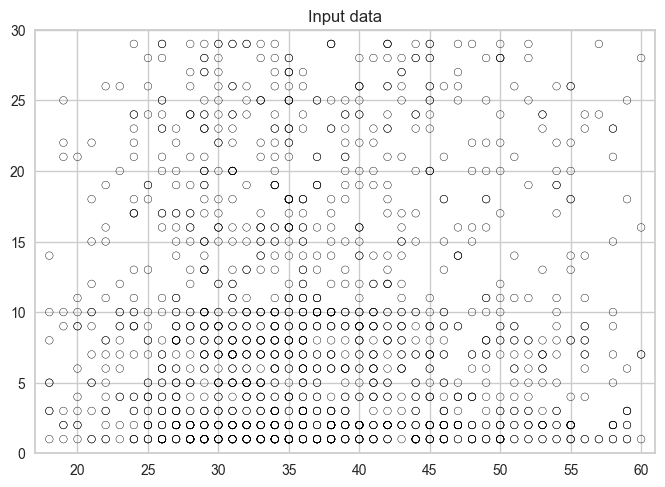

In [140]:
# Plot the input data
# a. creates figure
plt.figure()
plt.title('Input data')

# b. get the range of X and Y (long way)
# first column
x_min = X[:, 0].min()
x_max = X[:, 0].max()

# second column
y_min = X[:, 1].min()
y_max = X[:, 1].max()

# same as above: get the range of X and Y (short way)
# x_min, x_max = X[:, 0].min(), X[:, 0].max()
# y_min, y_max = X[:, 1].min(), X[:, 1].max()

# c. set plot limits
plt.xlim(x_min - 1, x_max + 1)
plt.ylim(y_min - 1, y_max + 1)

# plot the points
plt.scatter(X[:,0], X[:,1], marker='o', facecolors='none', edgecolors='black', s=30)

plt.show()

[271165.0170068028, 186360.69206838385, 129896.32617769884, 112084.2390394236, 94652.8081585521, 84234.5540175301, 79408.25516982753, 74830.71752369507, 70113.76160771403]


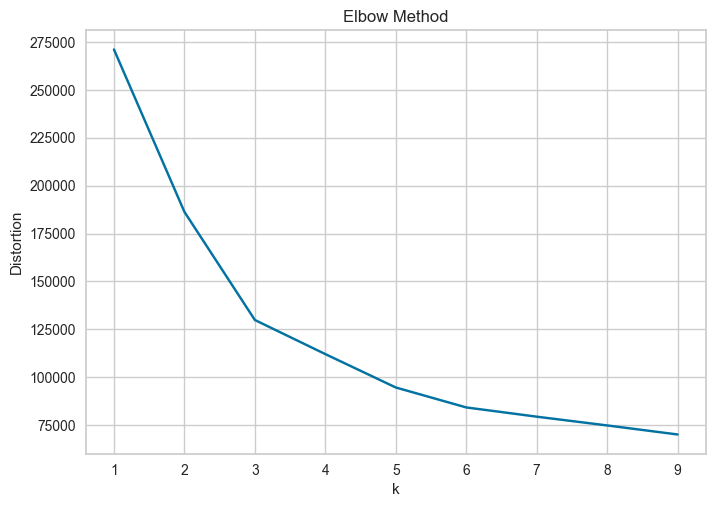

In [141]:
distortions = []
K = range(1, 10)
for k in K:
    KMmodel = KMeans(n_clusters=k)
    KMmodel.fit(X)
    distortions.append(KMmodel.inertia_)

print(distortions)

plt.title('Elbow Method')
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.show()

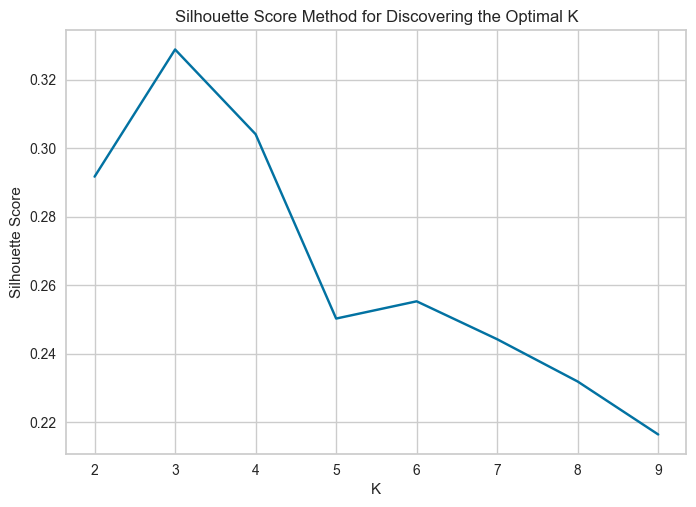

In [142]:
scores = []
K = range(2,10)
for k in K:
    KMmodel = KMeans(n_clusters=k, n_init=10)
    KMmodel.fit(X)
    score = silhouette_score(X, KMmodel.labels_, metric='euclidean', sample_size=len(X))
    scores.append(score)

# Plot the elbow
plt.title('Silhouette Score Method for Discovering the Optimal K')
plt.plot(K, scores, 'bx-')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.show()

Both methods seems to indicate that the best number of clusters is 3, but 6 might also provide a result. From a human perspective looking at the input data, it seems like two big clusters and one smaller cluster.

In [143]:
num_clusters = 3

KMmodel = KMeans(init="k-means++", n_clusters=num_clusters, n_init=20)
KMmodel.fit(X)

Y = KMmodel.predict(X)

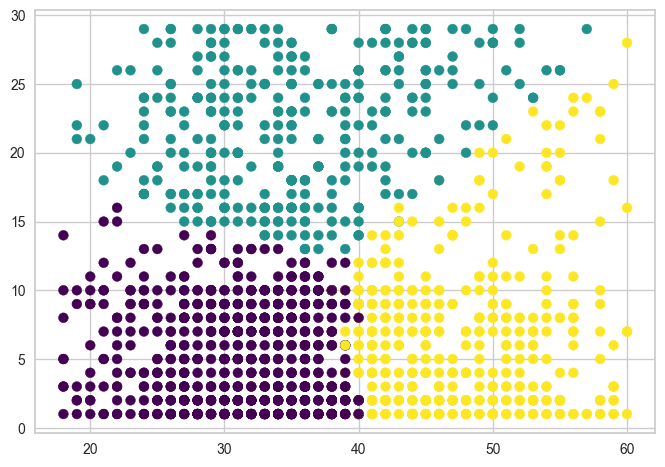

In [144]:
# Plot the points with color code of the predicted clusters
# viridis - a color map, https://matplotlib.org/users/colormaps.html
# s - marker size, here, the dots size
# c - marker color, here taken from the predicted clusters
plt.scatter(X[:, 0], X[:, 1], c=Y, s=50, cmap='viridis')

plt.grid(True)
plt.show()

### Validating model

In [145]:
KMmodel.predict(X)

score = silhouette_score(X, KMmodel.labels_, metric='euclidean')
print('Silhouette Score: %.3f' % score)

Silhouette Score: 0.329


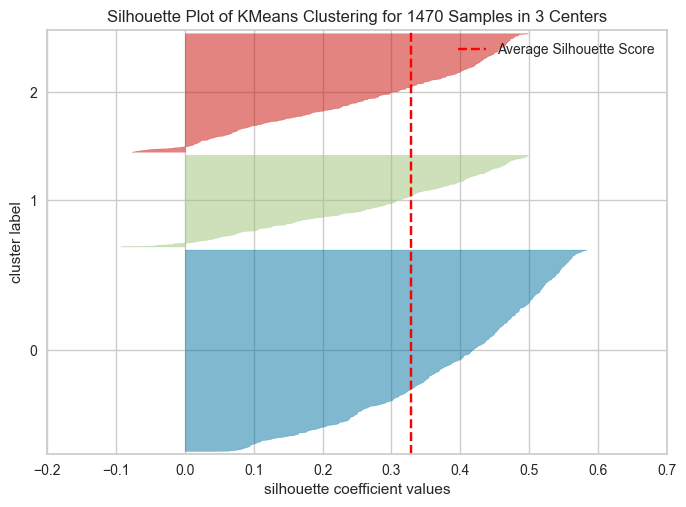

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 1470 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [146]:
# Visualize the silhouette scores of all points
visualizer = SilhouetteVisualizer(KMmodel, colors='yellowbrick')
visualizer.fit(X)
visualizer.show()  